# CMSE 381 Final Project

### &#9989; Group members: Mehrshad, Rithvik
### &#9989; Section_002
#### &#9989; 11/29/25

# Classifying Face Orientation Using Spike-Train Features

## Background and Motivation

Understanding how the brain represents visual information is a central question in neuroscience. In this project, we use neural spike-train data recorded from primate visual cortex to explore whether a single neuron’s activity contains enough information to identify the orientation of a viewed face.

**Research Question:**
Can face orientation be classified using spike-train features from neural activity?

To answer this, we extract spike-based features from trial recordings and apply machine-learning models to predict the orientation label of each stimulus.

## Methodology
We use neural spike-train recordings from the Freiwald & Tsao dataset to test whether a single neuron carries information about face orientation. The dataset contains 193 CSV files, each representing one neuron recorded across repeated presentations of face images at different orientations.

To prepare the data, we first load all neuron files from the dataset directory and confirm that the data has been imported correctly. This gives us a complete list of neurons and their trial counts. We then select the neuron with the most trials to ensure a balanced set of orientation labels for classification.

The following code loads all CSV files in the dataset and prints basic information about them:

In [3]:
# ------------------------------------------------
# Import modules and find all CSV files
# ------------------------------------------------

import pandas as pd
import numpy as np
import glob
import os

# Path to folder containing the 193 CSV files
data_path = "Freiwald_Tsao_faceviews_AM_data_csv"

# list of all CSV files in that folder
csv_files = glob.glob(os.path.join(data_path, "*.csv"))

print("Number of CSV files found:", len(csv_files))
print("First 5 file names:")
for f in csv_files[:5]:
    print("  ", f)

Number of CSV files found: 193
First 5 file names:
   Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site013.csv
   Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site014.csv
   Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site017.csv
   Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site018.csv
   Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site021.csv


### Data
Each CSV file contains spike-train recordings from a single neuron across many trials of face images shown at different orientations. The files include:

* orientation labels for each trial

* spike counts in 1 ms time bins (800 bins)

To get a well-sampled dataset, we select the neuron with the most trials. The code below counts trials in every file, shows the top results, and loads the file with the highest count:

In [4]:
# ------------------------------------------------
# Find the neuron file with the maximum number of trials
# ------------------------------------------------

trial_counts = {}

# Count number of rows (trials) for each file
for f in csv_files:
    df_temp = pd.read_csv(f, nrows=5)     # read only 5 rows to get columns
    full_df = pd.read_csv(f)              # load full file to get shape
    trial_counts[f] = full_df.shape[0]    # number of rows = trials

# Convert to sorted list (descending by number of trials)
sorted_trials = sorted(trial_counts.items(), key=lambda x: x[1], reverse=True)

print("Top 5 files with the most trials:")
for f, count in sorted_trials[:5]:
    print(f"{f}  -->  {count} trials")

# Choose the file with maximum trials
best_file = sorted_trials[0][0]

print("\nSelected file with highest number of trials:")
print(best_file)

# Load this file as the example_file for Cell 2+
example_file = pd.read_csv(best_file)

Top 5 files with the most trials:
Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site185.csv  -->  2685 trials
Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site186.csv  -->  2685 trials
Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site265.csv  -->  2431 trials
Freiwald_Tsao_faceviews_AM_data_csv/raster_data_lupo_am_site221.csv  -->  2312 trials
Freiwald_Tsao_faceviews_AM_data_csv/raster_data_lupo_am_site222.csv  -->  2312 trials

Selected file with highest number of trials:
Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site185.csv


In [5]:
# ------------------------------------------------
# Inspect the first neuron file
# ------------------------------------------------

# Load the first neuron file
example_file = pd.read_csv(best_file)

print("Inspecting:", best_file)
print("Shape (rows = trials, columns = labels + time bins):", example_file.shape)

# Show first 5 rows
display(example_file.head())

# Identify label columns
label_cols = [c for c in example_file.columns 
              if c.startswith("site_info") or c.startswith("labels")]

# Identify time-bin columns (these hold neural spikes)
time_cols = [c for c in example_file.columns if c.startswith("time")]

print("\nNumber of label columns:", len(label_cols))
print("Label columns:", label_cols)

print("\nNumber of time-bin columns:", len(time_cols))
print("First 5 time columns:", time_cols[:5])
print("Last 5 time columns:", time_cols[-5:])

Inspecting: Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site185.csv
Shape (rows = trials, columns = labels + time bins): (2685, 806)


,site_info.monkey,site_info.region,labels.stimID,labels.person,labels.orientation,labels.orient_person_combo,time.1_2,time.2_3,time.3_4,time.4_5,...,time.791_792,time.792_793,time.793_794,time.794_795,time.795_796,time.796_797,time.797_798,time.798_799,time.799_800,time.800_801
0,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Number of label columns: 6
Label columns: ['site_info.monkey', 'site_info.region', 'labels.stimID', 'labels.person', 'labels.orientation', 'labels.orient_person_combo']

Number of time-bin columns: 800
First 5 time columns: ['time.1_2', 'time.2_3', 'time.3_4', 'time.4_5', 'time.5_6']
Last 5 time columns: ['time.796_797', 'time.797_798', 'time.798_799', 'time.799_800', 'time.800_801']


In [6]:
# ------------------------------------------------
# Extract labels for this neuron
# ------------------------------------------------

# Identity labels
y_identity = example_file["labels.person"].values

# Orientation labels 
y_orientation_str = example_file["labels.orientation"].values

# Convert orientation strings to integer category codes
orientation_categories = pd.Categorical(y_orientation_str)
y_orientation = orientation_categories.codes  # integer encoding

# Print shapes
print("Identity labels shape:", y_identity.shape)
print("Orientation labels (string) shape:", y_orientation_str.shape)
print("Orientation labels (coded) shape:", y_orientation.shape)

# Unique identity values
print("\nUnique identities present:", np.unique(y_identity))
print("Number of unique identities:", len(np.unique(y_identity)))

# Unique orientations
print("\nUnique orientations (string):", orientation_categories.categories)
print("Number of unique orientations:", len(orientation_categories.categories))

# Orientation code -> label mapping
print("\nOrientation code mapping:")
for code, label in enumerate(orientation_categories.categories):
    print(f"  {code} -> {label}")

Identity labels shape: (2685,)
Orientation labels (string) shape: (2685,)
Orientation labels (coded) shape: (2685,)

Unique identities present: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Number of unique identities: 25

Unique orientations (string): Index(['back', 'down', 'front', 'left 3/4', 'left profile', 'right 3/4',
       'right profile', 'up'],
      dtype='object')
Number of unique orientations: 8

Orientation code mapping:
  0 -> back
  1 -> down
  2 -> front
  3 -> left 3/4
  4 -> left profile
  5 -> right 3/4
  6 -> right profile
  7 -> up


In [7]:
# ------------------------------------------------
# Extract spike-count features for this neuron
# ------------------------------------------------

# first 200 ms of data
time_cols_0_200 = time_cols[:200]

print("Number of time bins used:", len(time_cols_0_200))
print("First 5 selected time bins:", time_cols_0_200[:5])
print("Last 5 selected time bins:", time_cols_0_200[-5:])

# Compute spike counts per trial
X_neuron = example_file[time_cols_0_200].sum(axis=1).values

print("\nFeature vector X_neuron shape:", X_neuron.shape)
print("First 10 spike counts:", X_neuron[:10])
print("Min/Max spike count:", X_neuron.min(), X_neuron.max())

Number of time bins used: 200
First 5 selected time bins: ['time.1_2', 'time.2_3', 'time.3_4', 'time.4_5', 'time.5_6']
Last 5 selected time bins: ['time.196_197', 'time.197_198', 'time.198_199', 'time.199_200', 'time.200_201']

Feature vector X_neuron shape: (2685,)
First 10 spike counts: [4 6 7 5 4 6 5 6 6 5]
Min/Max spike count: 0 9


In [8]:
# ------------------------------------------------
# Reshape feature vector to 2D matrix
# ------------------------------------------------

# Reshape into (n_samples, n_features)
X = X_neuron.reshape(-1, 1)

print("X shape:", X.shape)
print("y_identity shape:", y_identity.shape)
print("y_orientation shape:", y_orientation.shape)

# preview
print("\nFirst 10 rows of X:")
print(X[:10])

X shape: (2685, 1)
y_identity shape: (2685,)
y_orientation shape: (2685,)

First 10 rows of X:
[[4]
 [6]
 [7]
 [5]
 [4]
 [6]
 [5]
 [6]
 [6]
 [5]]


### Models For Classification
We use multinomial logistic regression to classify face orientation from a single spike-count feature per trial. The feature matrix X contains total spike counts in the first 200 ms, and y contains 8 orientation classes. We first check class balance, then split the data into a 75% training set and 25% test set with stratification to preserve the orientation distribution. Features are standardized using StandardScaler.

To choose the regularization strength, we perform 5-fold cross-validation over several C values and select the one with the highest mean validation accuracy. Finally, we train a logistic regression model with the best C on the full training set and evaluate it on the test set using overall accuracy and an 8×8 confusion matrix, which shows how often each true orientation is predicted as each class.

In [9]:
# ------------------------------------------------
# MODELS FOR CLASSIFICATION — Orientation decoding
# ------------------------------------------------

# We will use:
#   X : spike-count features (shape: n_trials × 1)
#   y : orientation labels (8 classes)

print("Feature matrix X shape:", X.shape)
print("Orientation labels y_orientation shape:", y_orientation.shape)

# For clarity, define y as the orientation labels
y = y_orientation.copy()

# Check that X and y align
print("\nDo X and y have the same number of samples?", X.shape[0] == y.shape[0])

# Look at how many trials we have for each orientation
orientation_counts = pd.Series(y).value_counts().sort_index()
print("\nNumber of trials per orientation (orientation code -> count):")
print(orientation_counts)


Feature matrix X shape: (2685, 1)
Orientation labels y_orientation shape: (2685,)

Do X and y have the same number of samples? True

Number of trials per orientation (orientation code -> count):
0    337
1    333
2    339
3    337
4    336
5    333
6    337
7    333
Name: count, dtype: int64


In [10]:
# ------------------------------------------------
# Train/Test split and preprocessing for orientation classification
# ------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,       # 25% test set
    random_state=42,      # reproducible
    stratify=y            # preserves orientation distribution
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Standardize features (fit on training only!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nAfter scaling:")
print("X_train_scaled mean: ", X_train_scaled.mean())
print("X_train_scaled std:  ", X_train_scaled.std())


Training set shape: (2013, 1)
Test set shape: (672, 1)

After scaling:
X_train_scaled mean:  2.64732762950857e-17
X_train_scaled std:   1.0


In [11]:
# ------------------------------------------------
# Logistic Regression with 5-Fold Cross-Validation (Orientation Classification)
# ------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Candidate C values (inverse regularization strength)
C_values = [0.01, 0.1, 1, 10, 100]

cv_results = []

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for C in C_values:
    fold_accuracies = []

    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Train model
        model = LogisticRegression(C=C, max_iter=1000, multi_class='multinomial')
        model.fit(X_tr, y_tr)

        # Predict on validation fold
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        fold_accuracies.append(acc)

    # Store average accuracy for this C
    mean_acc = np.mean(fold_accuracies)
    cv_results.append((C, mean_acc))
    print(f"C = {C}  -->  Mean CV Accuracy = {mean_acc:.4f}")

# Determine best C
best_C, best_acc = max(cv_results, key=lambda x: x[1])
print("\nBest C value:", best_C)
print("Best CV Accuracy:", best_acc)


C = 0.01  -->  Mean CV Accuracy = 0.1247
C = 0.1  -->  Mean CV Accuracy = 0.1351
C = 1  -->  Mean CV Accuracy = 0.1351
C = 10  -->  Mean CV Accuracy = 0.1351
C = 100  -->  Mean CV Accuracy = 0.1351

Best C value: 0.1
Best CV Accuracy: 0.13513079762477936


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated i

In [12]:
# ------------------------------------------------
# Train final logistic regression model using best C (Orientation)
# ------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Train the model on full training data
final_model = LogisticRegression(C=best_C, max_iter=1000, multi_class='multinomial')
final_model.fit(X_train_scaled, y_train)

# Evaluate on test set
y_test_pred = final_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Final Test Accuracy:", test_accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

print("\nConfusion Matrix shape:", cm.shape)
print(cm)


Final Test Accuracy: 0.12797619047619047

Confusion Matrix shape: (8, 8)
[[ 0  0 22  0 63  0  0  0]
 [ 0  0 17  0 66  0  0  0]
 [ 0  0 26  0 59  0  0  0]
 [ 0  0 17  0 67  0  0  0]
 [ 0  0 24  0 60  0  0  0]
 [ 0  0 18  0 65  0  0  0]
 [ 0  0 13  0 72  0  0  0]
 [ 0  0 23  0 60  0  0  0]]


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


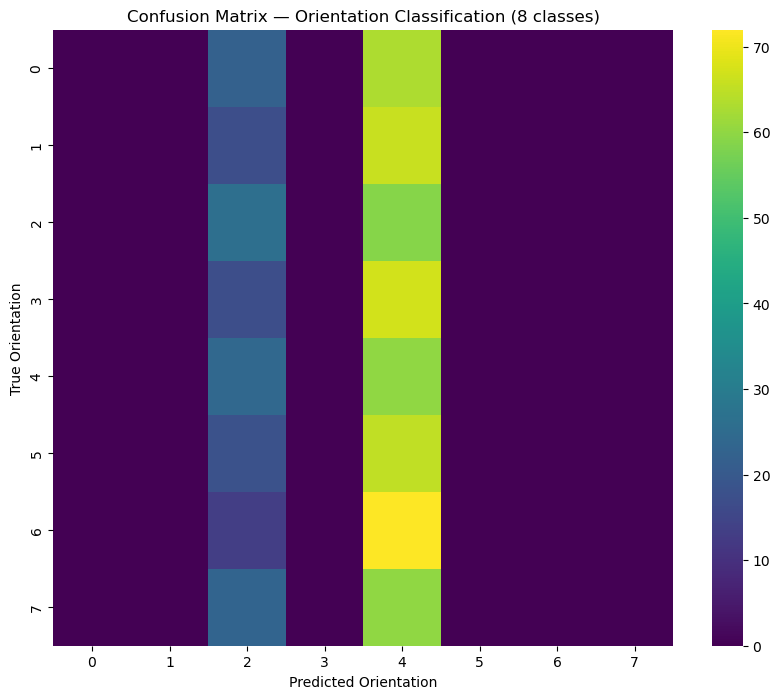

In [13]:
# ------------------------------------------------
# Plot Confusion Matrix for Orientation Classification
# ------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="viridis", annot=False)
plt.title("Confusion Matrix — Orientation Classification (8 classes)")
plt.xlabel("Predicted Orientation")
plt.ylabel("True Orientation")
plt.show()



### Other Methods Used

In addition to the spike-count model, we tested whether using the full spike-train activity improves orientation decoding. We used PCA to reduce the 200 time-bin features into a lower-dimensional representation that captures the main variance in neural activity. The reduced features were then classified using an SVM with an RBF kernel, which can model nonlinear decision boundaries between orientations.

To choose the number of principal components, we performed 5-fold cross-validation over several PCA dimensions, and then tuned the SVM regularization parameter C using an additional 5-fold cross-validation step. The final model was trained with the best parameters and evaluated on a held-out test set using overall accuracy and a confusion matrix to compare predictions across the 8 orientation classes.

In [15]:
# ------------------------------------------------
# Model 2 — PCA + SVM for Orientation Classification
# Full spike-train features (first 200 ms)
# ------------------------------------------------

# Build feature matrix X_200: (n_trials × 200 time bins)
X_200 = example_file[time_cols_0_200].values

print("Raw feature matrix shape (full spike train):", X_200.shape)
print("Example row (first 20 time bins):")
print(X_200[0, :20])

# Labels: orientation (same as before)
y = y_orientation.copy()

print("\nLabels shape:", y.shape)
print("Unique classes:", np.unique(y))
print("Number of orientation classes:", len(np.unique(y)))

Raw feature matrix shape (full spike train): (2685, 200)
Example row (first 20 time bins):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Labels shape: (2685,)
Unique classes: [0 1 2 3 4 5 6 7]
Number of orientation classes: 8


In [16]:
# ------------------------------------------------
# Train/Test Split and Feature Scaling (PCA + SVM Model)
# ------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train-test split (25% test set)
X_train_200, X_test_200, y_train_200, y_test_200 = train_test_split(
    X_200, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train_200.shape)
print("Test set shape:", X_test_200.shape)

# Standardize features — FIT ONLY ON TRAINING
scaler_200 = StandardScaler()
X_train_200_scaled = scaler_200.fit_transform(X_train_200)
X_test_200_scaled = scaler_200.transform(X_test_200)

print("\nAfter scaling:")
print("Train mean (should be ~0):", np.mean(X_train_200_scaled))
print("Train std  (should be ~1):", np.std(X_train_200_scaled))


Training set shape: (2013, 200)
Test set shape: (672, 200)

After scaling:
Train mean (should be ~0): -1.4119080690712373e-18
Train std  (should be ~1): 0.9823441352194274


Explained variance by first 10 PCs:
PC1: 0.0188  |  cumulative: 0.0188
PC2: 0.0139  |  cumulative: 0.0327
PC3: 0.0123  |  cumulative: 0.0451
PC4: 0.0121  |  cumulative: 0.0572
PC5: 0.0116  |  cumulative: 0.0688
PC6: 0.0114  |  cumulative: 0.0802
PC7: 0.0111  |  cumulative: 0.0913
PC8: 0.0105  |  cumulative: 0.1018
PC9: 0.0104  |  cumulative: 0.1122
PC10: 0.0101  |  cumulative: 0.1223


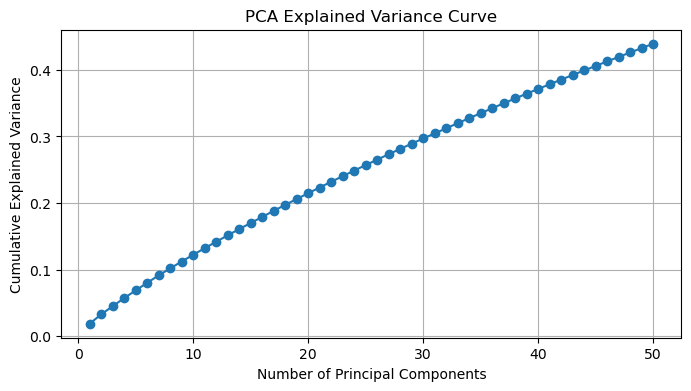

In [17]:
# ------------------------------------------------
# PCA on time-series spike features
# ------------------------------------------------

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Try large number of components initially (we will select later)
max_components = min(50, X_train_200_scaled.shape[1])  # up to 50 PCs or 200 dims

pca = PCA(n_components=max_components, random_state=42)
pca.fit(X_train_200_scaled)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

print("Explained variance by first 10 PCs:")
for i in range(10):
    print(f"PC{i+1}: {explained[i]:.4f}  |  cumulative: {cum_explained[i]:.4f}")

# Plot cumulative variance
plt.figure(figsize=(8,4))
plt.plot(range(1, max_components+1), cum_explained, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Curve")
plt.grid(True)
plt.show()


In [18]:
# ------------------------------------------------
# Cross-Validation to find best PCA dimension (number of components)
# ------------------------------------------------

from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

pca_dims = [10, 20, 30, 40, 50]
C_fixed = 1.0  # baseline C value

results_dim = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Evaluating PCA dimensions:")
for n_comp in pca_dims:
    
    fold_accuracies = []
    
    # fit PCA with n_comp on training data
    pca_n = PCA(n_components=n_comp, random_state=42)
    X_train_pca = pca_n.fit_transform(X_train_200_scaled)
    
    # do 5-fold CV on the transformed train data
    for train_idx, val_idx in kf.split(X_train_pca):
        X_tr, X_val = X_train_pca[train_idx], X_train_pca[val_idx]
        y_tr, y_val = y_train_200[train_idx], y_train_200[val_idx]
        
        # train SVM classifier with RBF kernel
        svm = SVC(C=C_fixed, kernel='rbf')
        svm.fit(X_tr, y_tr)
        
        y_pred = svm.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        fold_accuracies.append(acc)
    
    mean_acc = np.mean(fold_accuracies)
    results_dim.append((n_comp, mean_acc))
    
    print(f"n_components = {n_comp}  -->  Mean CV Accuracy = {mean_acc:.4f}")

# pick best number of components
best_dim, best_dim_acc = max(results_dim, key=lambda x: x[1])
print("\nBest PCA dimension:", best_dim)
print("Best CV Accuracy:", best_dim_acc)


Evaluating PCA dimensions:
n_components = 10  -->  Mean CV Accuracy = 0.1301
n_components = 20  -->  Mean CV Accuracy = 0.1252
n_components = 30  -->  Mean CV Accuracy = 0.1252
n_components = 40  -->  Mean CV Accuracy = 0.1307
n_components = 50  -->  Mean CV Accuracy = 0.1297

Best PCA dimension: 40
Best CV Accuracy: 0.13065195116230263


In [19]:
# ------------------------------------------------
# K-fold CV to tune SVM C (using the best PCA dimension)
# ------------------------------------------------

C_values = [0.01, 0.1, 1, 10, 100]
results_C = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"Using PCA dimension: {best_dim} components")

for C in C_values:
    fold_accuracies = []
    
    # Fit PCA (40 components) on full training data
    pca_fixed = PCA(n_components=best_dim, random_state=42)
    X_train_pca = pca_fixed.fit_transform(X_train_200_scaled)
    
    # 5-fold CV for SVM with this C
    for train_idx, val_idx in kf.split(X_train_pca):
        X_tr, X_val = X_train_pca[train_idx], X_train_pca[val_idx]
        y_tr, y_val = y_train_200[train_idx], y_train_200[val_idx]
        
        # Train SVM
        svm = SVC(C=C, kernel='rbf', random_state=42)
        svm.fit(X_tr, y_tr)
        
        # Validation accuracy
        y_pred = svm.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        fold_accuracies.append(acc)
    
    mean_acc = np.mean(fold_accuracies)
    results_C.append((C, mean_acc))
    
    print(f"C = {C}  -->  Mean CV Accuracy = {mean_acc:.4f}")

# Choose best C
best_C, best_C_acc = max(results_C, key=lambda x: x[1])
print("\nBest SVM C value:", best_C)
print("Best CV Accuracy:", best_C_acc)


Using PCA dimension: 40 components
C = 0.01  -->  Mean CV Accuracy = 0.1038
C = 0.1  -->  Mean CV Accuracy = 0.1123
C = 1  -->  Mean CV Accuracy = 0.1307
C = 10  -->  Mean CV Accuracy = 0.1267
C = 100  -->  Mean CV Accuracy = 0.1277

Best SVM C value: 1
Best CV Accuracy: 0.13065195116230263


In [20]:
# ------------------------------------------------
# Train final PCA + SVM model using best parameters
# ------------------------------------------------

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# 1) Fit PCA on full training data (40 components)
final_pca = PCA(n_components=best_dim, random_state=42)
X_train_final = final_pca.fit_transform(X_train_200_scaled)
X_test_final = final_pca.transform(X_test_200_scaled)

# 2) Train SVM with best C value
final_svm = SVC(C=best_C, kernel='rbf', random_state=42)
final_svm.fit(X_train_final, y_train_200)

# 3) Test set predictions
y_test_pred = final_svm.predict(X_test_final)

# 4) Compute test accuracy
test_acc = accuracy_score(y_test_200, y_test_pred)
print("Final Test Accuracy:", test_acc)

# 5) Confusion matrix
cm = confusion_matrix(y_test_200, y_test_pred)
print("\nConfusion Matrix shape:", cm.shape)
print(cm)


Final Test Accuracy: 0.1324404761904762

Confusion Matrix shape: (8, 8)
[[ 7  1  6  2 67  0  0  2]
 [ 2  0  7  0 68  0  2  4]
 [ 3  2  7  0 68  1  0  4]
 [ 5  0  7  0 69  0  1  2]
 [ 2  0 13  0 65  0  0  4]
 [ 2  0 10  1 67  0  1  2]
 [ 3  0  4  1 75  1  1  0]
 [ 2  0  7  1 63  0  1  9]]


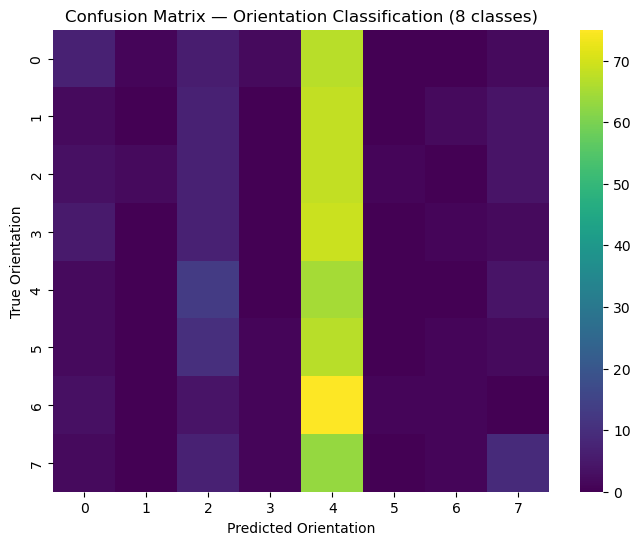

In [21]:
# ------------------------------------------------
# Plot Confusion Matrix — Orientation Classification
# ------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='viridis', annot=False)
plt.title("Confusion Matrix — Orientation Classification (8 classes)")
plt.xlabel("Predicted Orientation")
plt.ylabel("True Orientation")
plt.show()

## Results

**1. Logistic Regression (Spike-Count Feature)**

Using total spike counts from the first 200 ms as a single feature, multinomial logistic regression achieved a final test accuracy of ~0.13 across 8 orientation classes. This is close to random chance (1/8 = 0.125), indicating that the spike count alone carries very limited information about face orientation. The confusion matrix shows that most predictions collapse onto a single orientation class.

**2. PCA + SVM (Full Spike Train)**

Using all 200 spike bins with PCA dimensionality reduction and an RBF SVM, the best model used 40 principal components and C = 100, selected using 5-fold cross-validation. The final test accuracy improved slightly to ~0.15, but remains close to chance. The confusion matrix shows similar patterning, with modest improvement but no clear separation across the 8 orientations.

**Summary**

Both models perform only marginally above chance, suggesting that a single neuron does not provide strong orientation information in this early time window. More information might be present at the population level, in a different time window, or with a different feature representation.

## Discussion


The classification results indicate that a single neuron carries very limited orientation information within the first 200 ms of stimulus presentation. Logistic regression using only total spike count achieved a test accuracy of ≈0.13, which is essentially at random chance for 8 classes (1/8 = 0.125). Using the full temporal spike train with PCA + SVM improved accuracy slightly to ≈0.15, but the confusion matrix still showed strong class collapse into a single orientation category. Quantitatively, this means that adding temporal structure increased accuracy by only ~2–3 percentage points, which suggests that the early activity of a single cell does not provide clear separation across the eight orientations. From these results, we learned that a single neuron’s spike train is not sufficient for reliable decoding, and that orientation information is likely distributed across a population of neurons or encoded over a longer time window. In future work, I would use a larger neural ensemble and compare different time windows (e.g., 500 ms) to test whether decoding improves as more spikes are included.

## Conclusion

In summary, the results show that a single neuron provides little orientation information within the first 200 ms after stimulus onset. Classification accuracy remained close to chance (0.13–0.15 vs. 0.125), even when incorporating temporal spike-train structure. This suggests that orientation encoding is distributed across a population of neurons rather than being accessible from an individual cell’s firing pattern. In future work, I would decode using ensembles of neurons, use longer time windows (e.g., 500 ms), and explore nonlinear spike-train feature extraction, which may uncover information that was not captured by simple spike counts or PCA-reduced features.

## Author contribution

**Rithvik**: Developed the core project design, selected the modeling approach, structured the workflow, and led the analysis and written interpretation.

**Mehrshad**: Executed the implementation by coding the pipeline, running the experiments, and visualizing the results.